# Appliance Energy Prediction
## Nelson Guayazan, Emanuel Naval y Victor Sicachá 

La base de datos a analizar consta de medidas tomadas cada 10 minutos durante un periodo de 4 meses y medio (desde el 11 de enero hasta el 27 de mayo) del gasto de energía y luz en una casa ubicada en Bélgica en el año 2016. Adicionalmente se tienen en cuenta factores como la temperatura y humedad de cada habitación de la casa, el clima registrado por el aeropuerto más cercano (Chievres Airport) así como la velocidad del viento y la temperatura y humedad del ambiente.

In [405]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import numpy as np
#import prophet as ph
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

from skforecast.model_selection import time_series_spliter


import warnings
warnings.filterwarnings('ignore')

plt.rc('figure', figsize=(25, 9))

## Análisis exploratorio de los datos
### Configuración del dataset

Al cargar la base de datos eliminamos dos columnas que no brindan información alguna para el análisis: 'rv1' y 'rv2'. Adicionalmente, las características de la temperatura y humedad de los cuartos de la casa fueron renombradas para mejorar su futuro tratamiento y manipulación.

In [381]:
df_complete = pd.read_csv("energydata.csv", index_col='date').drop(columns = ['rv1', 'rv2'])
rooms = {
    "T1": "T_kitchen",
    "RH_1": "RH_kitchen",
    "T2": "T_living",
    "RH_2": "RH_living",
    "T3": "T_laundry",
    "RH_3": "RH_laundry",
    "T4": "T_office",
    "RH_4": "RH_office",
    "T5": "T_bathroom",
    "RH_5": "RH_bathroom",
    "T6": "T_out_building",
    "RH_6": "RH_out_building",
    "T7": "T_ironing",
    "RH_7": "RH_ironing",
    "T8": "T_teenager",
    "RH_8": "RH_teenager",
    "T9": "T_parents",
    "RH_9": "RH_parents",
}
df_complete = df_complete.rename(columns = rooms, errors="raise")
df_complete.head()

,Appliances,lights,T_kitchen,RH_kitchen,T_living,RH_living,T_laundry,RH_laundry,T_office,RH_office,...,T_teenager,RH_teenager,T_parents,RH_parents,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


Luego de cargar los datos y realizar una revisión detallada de los mismos se eliminaron la primer y última semana del dataset ya que estas contaban con registros incompletos que prodrían afectar los resultados de los futuros modelos y sus análisis.

In [382]:
dates = list(df_complete.index)
for i in dates:
    if pd.Timestamp(i).week == 2 or pd.Timestamp(i).week == 21:
        df_complete = df_complete.drop(i, axis = 0)

Por otro lado, el momento del día es muy importante para el análisis de los datos pues, al tratarse de valores de consumo energético, es natural que al anochecer los valores cambien significativamente en comparación con el día. Es por esto que será agregada una nueva columna al dataset que identifique si la muestra fue tomada en el día o la noche.

In [383]:
# Función para establecer el estado del dato (día o noche)
def imputation_mean_daynight(X):
    dia_noche= []
    date = X.index
    for i in range(len(date)):
        if pd.Timestamp(date[i]).week in [3,4]:
            if pd.Timestamp(date[i]).hour in [0,1,2,3,4,5,6,7,17,18,19,20,21,22,23]:
                dia_noche.append(0)
            else:
                dia_noche.append(1)
        elif pd.Timestamp(date[i]).week in [5,6,7,8,9]:
            if pd.Timestamp(date[i]).hour in [0,1,2,3,4,5,6,7,18,19,20,21,22,23]:
                dia_noche.append(0)
            else:
                dia_noche.append(1)
        elif pd.Timestamp(date[i]).week in [10,11,12,13]:
            if pd.Timestamp(date[i]).hour in [0,1,2,3,4,5,6,19,20,21,22,23]:
                dia_noche.append(0)
            else:
                dia_noche.append(1)    
        elif pd.Timestamp(date[i]).week in [14,15,16,17]:
            if pd.Timestamp(date[i]).hour in [0,1,2,3,4,5,6,20,21,22,23]:
                dia_noche.append(0)
            else:
                dia_noche.append(1)
        elif pd.Timestamp(date[i]).week in [18,19,20]:
            if pd.Timestamp(date[i]).hour in [0,1,2,3,4,5,21,22,23]:
                dia_noche.append(0)
            else:
                dia_noche.append(1)         
    return dia_noche

In [384]:
dia = imputation_mean_daynight(df_complete)
df_complete["day_status"] = dia
df_complete.head()

,Appliances,lights,T_kitchen,RH_kitchen,T_living,RH_living,T_laundry,RH_laundry,T_office,RH_office,...,RH_teenager,T_parents,RH_parents,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,day_status
date,,,,,,,,,,,,,,,,,,,,,
2016-01-18 00:00:00,60,10,21.823333,39.900000,20.230000,40.0000,20.323333,39.79,21.166667,39.863333,...,44.400000,17.600000,38.400000,-2.800000,763.700000,86.0,2.0,25.0,-4.900000,0
2016-01-18 00:10:00,50,10,21.790000,39.933333,20.166667,40.0900,20.390000,39.79,21.100000,39.826667,...,44.845000,17.666667,38.466667,-2.883333,763.583333,86.0,2.0,25.5,-4.983333,0
2016-01-18 00:20:00,40,10,21.730000,40.000000,20.075000,40.0675,20.323333,39.79,21.100000,39.900000,...,45.300000,17.600000,38.400000,-2.966667,763.466667,86.0,2.0,26.0,-5.066667,0
2016-01-18 00:30:00,30,20,21.666667,40.000000,20.000000,40.0000,20.290000,39.70,21.100000,39.933333,...,45.560000,17.600000,38.466667,-3.050000,763.350000,86.0,2.0,26.5,-5.150000,0
2016-01-18 00:40:00,40,0,21.600000,40.193333,19.945000,40.0000,20.260000,39.76,21.100000,40.000000,...,45.466667,17.600000,38.590000,-3.133333,763.233333,86.0,2.0,27.0,-5.233333,0


### Visualización

Iniciamos la visualización con dos de las variables más significativas de la base de datos: Appliances y lights. Cada una será graficada con los datos pertenecientes a unos pocos días en específico para que su visualización sea más amigable.

2021-11-21 18:24:40,477 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:40,508 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:40,540 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:40,571 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:40,589 matplotlib.categ

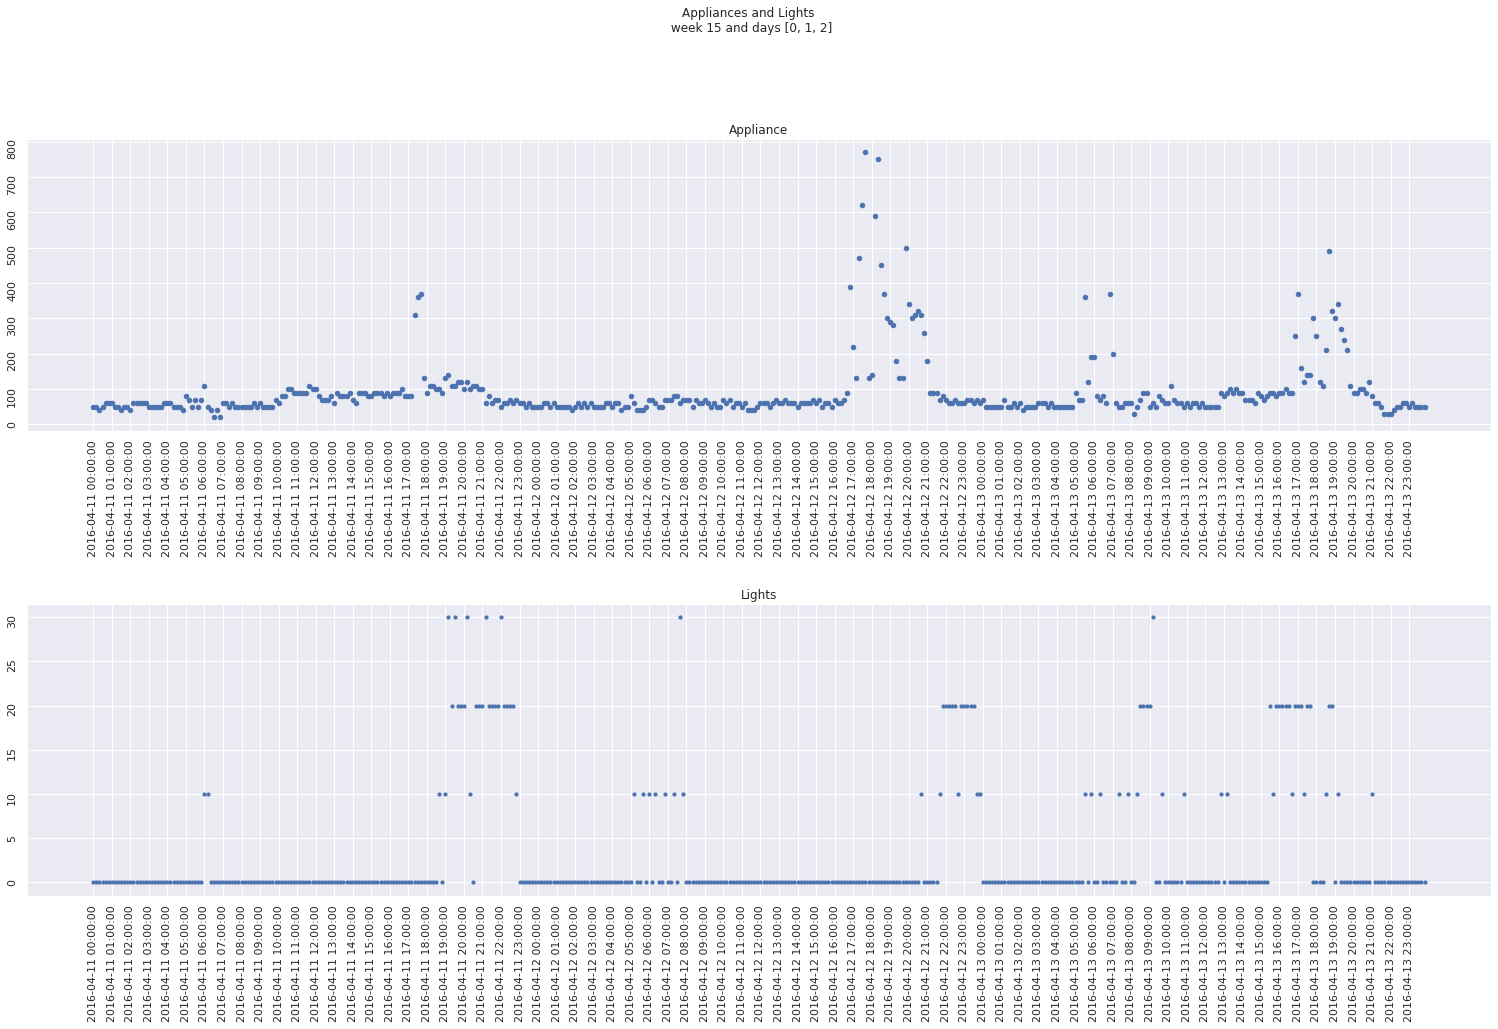

In [385]:
# Configuración semana y días de la semana (puede cambiar para revisar)
week = 15 # número entre 3 y 20
weekdays = [0,1,2] # números entre 0 y 6
# Variables para la visualización
dates = list(df_complete.index)
X = []
y_appliances = []
y_lights = []
# Recolección de valores
for i in dates:
    if pd.Timestamp(i).week == week and pd.Timestamp(i).weekday() in weekdays:
        a = df_complete['Appliances'][i]
        l = df_complete['lights'][i]
        y_appliances.append(a)
        y_lights.append(l)
        X.append(i)
# Graficas
fig, axs = plt.subplots(2, figsize=(25, 15))
fig.tight_layout(pad=15)
# Disminuyendo el número de ticks para mejorar legibilidad
xticks = []
for i in X:
    if pd.Timestamp(i).minute == 0:
        xticks.append(i)
# Configuración de las gráficas
fig.suptitle(f'Appliances and Lights \n week {week} and days {weekdays}')
axs[0].scatter(X,y_appliances, s = 20)
axs[1].scatter(X,y_lights, s = 10)
axs[0].tick_params(labelrotation=90)
axs[1].tick_params(labelrotation=90)
axs[0].axes.get_xaxis().set_ticks(xticks)
axs[1].axes.get_xaxis().set_ticks(xticks)
axs[0].set_title("Appliance")
axs[1].set_title("Lights")
plt.show()

Luego, se verá el comportamiento de la temperatura y humedad a través del tiempo en cada una de las habitaciones de la casa. Para ello se creó una función que toma el nombre de una habitación y grafica sus valores, de temperatura y humedad, dentro de un rango de tiempo determinado.

In [386]:
def scatter_temp_rh(room, week = 3, days = [0,1,2,3,4,5,6,7]):
    """
    Función que toma el nombre de una habitación y plotea sus 
    valores de humedad y temperatura en la semana y días establecidos.
    EJEMPLO: scatter_temp_rh("kitchen")
    """
    X = []
    T = []
    RH = []
    for i in dates:
        if pd.Timestamp(i).week == week and pd.Timestamp(i).weekday() in days:
            T.append(df_complete[f'T_{room}'][i])
            RH.append(df_complete[f'RH_{room}'][i])
            X.append(i)
    xticks = []
    for i in X:
        if pd.Timestamp(i).minute == 0:
            xticks.append(i)    
    fig, axs = plt.subplots(2, figsize=(25, 15))
    fig.tight_layout(pad=15)

    fig.suptitle(f'Date vs temperature and humity in the {room} \n on days {days} of the week {week}')
    axs[0].scatter(X,T, s = 20)
    axs[1].scatter(X,RH, s = 20)
    axs[0].tick_params(labelrotation=90)
    axs[1].tick_params(labelrotation=90)
    axs[0].axes.get_xaxis().set_ticks(xticks)
    axs[1].axes.get_xaxis().set_ticks(xticks)
    axs[0].set_title(f"Temperature in {room}")
    axs[1].set_title(f"RH in {room}")
    plt.show()

En el siguiente cuadro de código se listan las habitaciones de la casa las cuales pueden ser ingresadas en la función. Con el objetivo de no imprimir tantas gráficas invitamos al lector para que interactúe e ingrese la habitación que desea ver en el tiempo determinado. Se mostrarán dos graficas: La primera entre la semana 3 y 11 la  las cuales corresponden a las semanas con datos registrados en `invierno`. La segunda será entre la semana 12 y la 20 las cuales corresponden a las semanas con datos registrados en `primavera`.

2021-11-21 18:24:52,563 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:52,613 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:52,652 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:52,685 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:52,712 matplotlib.categ

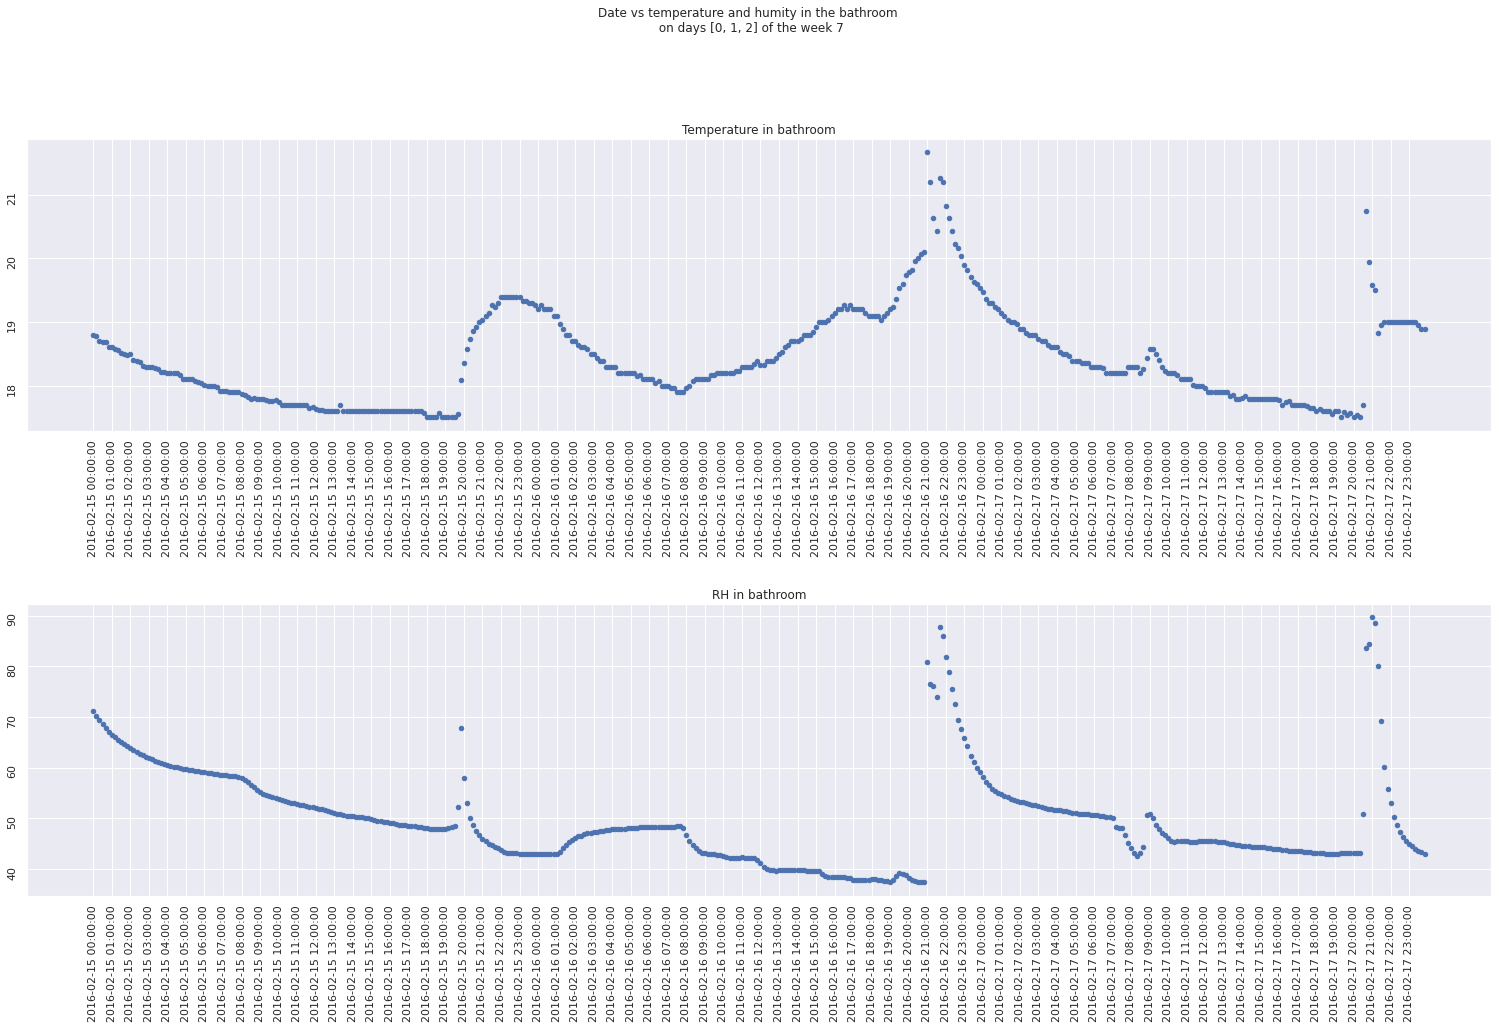

2021-11-21 18:24:57,094 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:57,121 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:57,150 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:57,181 matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-11-21 18:24:57,205 matplotlib.categ

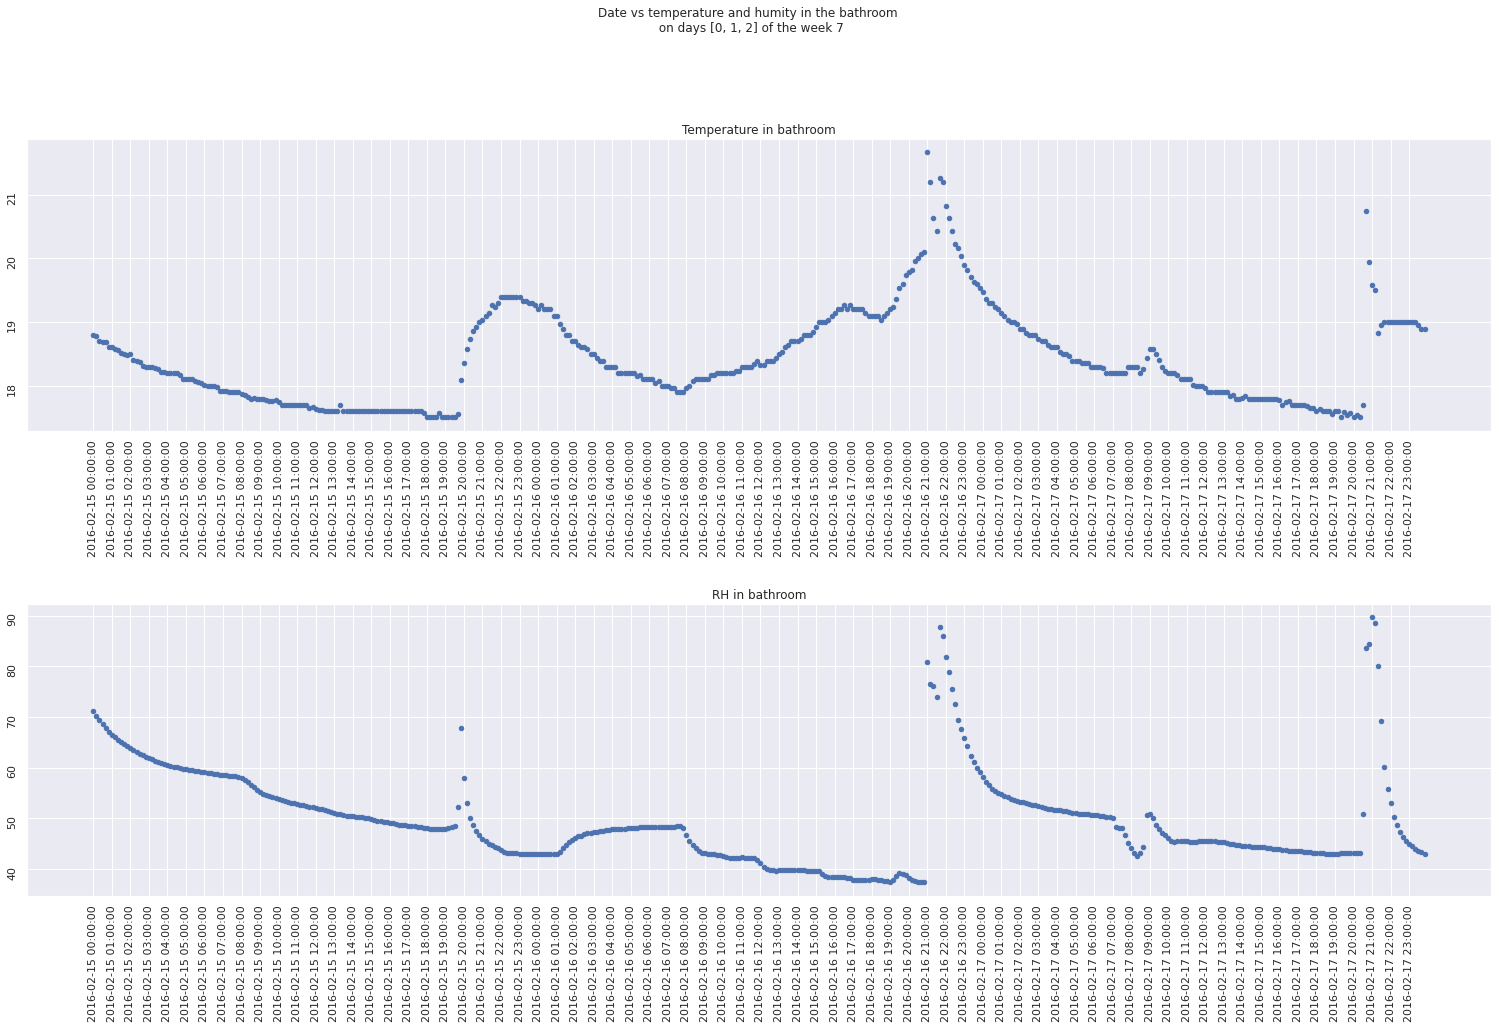

In [387]:
# Rooms: kitchen living laundry office bathroom out_building ironing teenager parents out
room = 'bathroom'
days = [0,1,2]
week = 7
scatter_temp_rh(room, week = week, days = days)
scatter_temp_rh(room, week = week, days = days)

Durante diferentes visualizaciones realizadas durante la implementación de este análisis encontramos que la umedad tiene cambios muy bruscos en su comportamiento pues en poco tiempo su valor sube de gran manera y comienza a disminuir lentamente. Esto puede ser debido a cambios momentaneos en el clima como la lluvia. Por otro lado, la temperatura en algunos casos tiene un comportamiento inversamente proporcional o directamente proporcional al comportamiento de la humedad, esto depende de la abitación o de la estación del año. Note además que las semanas de los meses entre Enero y Marzo la temperatura ambiente promedio está entre 0 y 7 C° debido a que se encuentra en invierno. Las semanas de los meses entre Abril y Mayo la temperatura ambiente promedio se encuentra entre 10 y 15 C°, pues se está en primavera.

## Elección y ajuste de modelos

Inicialmente queremos verificar que la variable Appliances es una serie temporal estacionaria para porder aplicar los modelos de AR y ARIMA sin problema. Para ello realizaremos la prueba de *Dickey Fuller* aumentada.

### Prueba Dickey Fuller aumentada

Creamos la serie temporal a partir de la base de datos original para trabajar con ella.

<AxesSubplot:xlabel='date'>

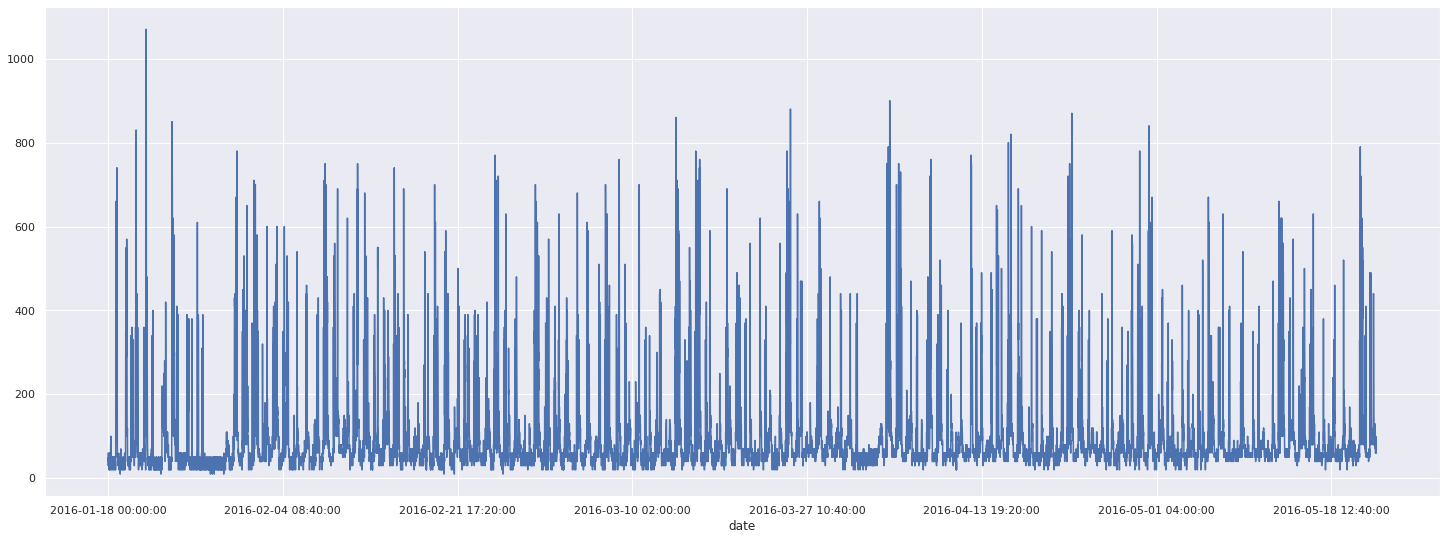

In [330]:
s_appli = pd.Series(df_complete.values[:,0], index=df_complete.index)
s_appli.plot()

Realizamos la prueba con la función *adfuller* perteneciente a la librería Statsmodels.

In [331]:
Xa = s_appli.values

result_a = adfuller(Xa)
print('ADF Statistic: %f' % result_a[0])
print('p-value: %f' % result_a[1])
print('Critical Values:')
for key, value in result_a[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.291104
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Como el valor del **ADF Statistic** es $-20.2911$ el cual es menor al 1% del valor critico $-3.431$ con p valor muy cercano a cero. Por lo tanto se rechaza la hipótesis nula la cual supone que la serie temporal es no estacionaria y, de este modo, podemos continuar con la formulación de los modelos.

### Modelo de persistencia

Luego, iniciamos con con el modelo más básico para la predicción de series temporales: *Modelo de persistencia*.

In [332]:
# Modelo Persistencia
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order

In [388]:
# Create lagged dataset
values = pd.DataFrame(s_appli.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
df.head()

,t,t+1
0,NaN,60.0
1,60.0,50.0
2,50.0,40.0
3,40.0,30.0
4,30.0,40.0


Dividimos el conjunto de datos en test y train.

In [335]:
# Modelo de persistencia
Xa = df.values
train_size = int(len(Xa) * 0.66)
train_a, test_a = Xa[1:train_size], Xa[train_size:]

train_ax, train_ay = train_a[:,0], train_a[:,1]
test_ax, test_ay = test_a[:,0], test_a[:,1]

In [336]:
print('Observations: %d' % (len(Xa)))
print('Training Observations: %d' % (len(train_a)))
print('Testing Observations: %d' % (len(test_a)))

Observations: 18144
Training Observations: 11974
Testing Observations: 6169


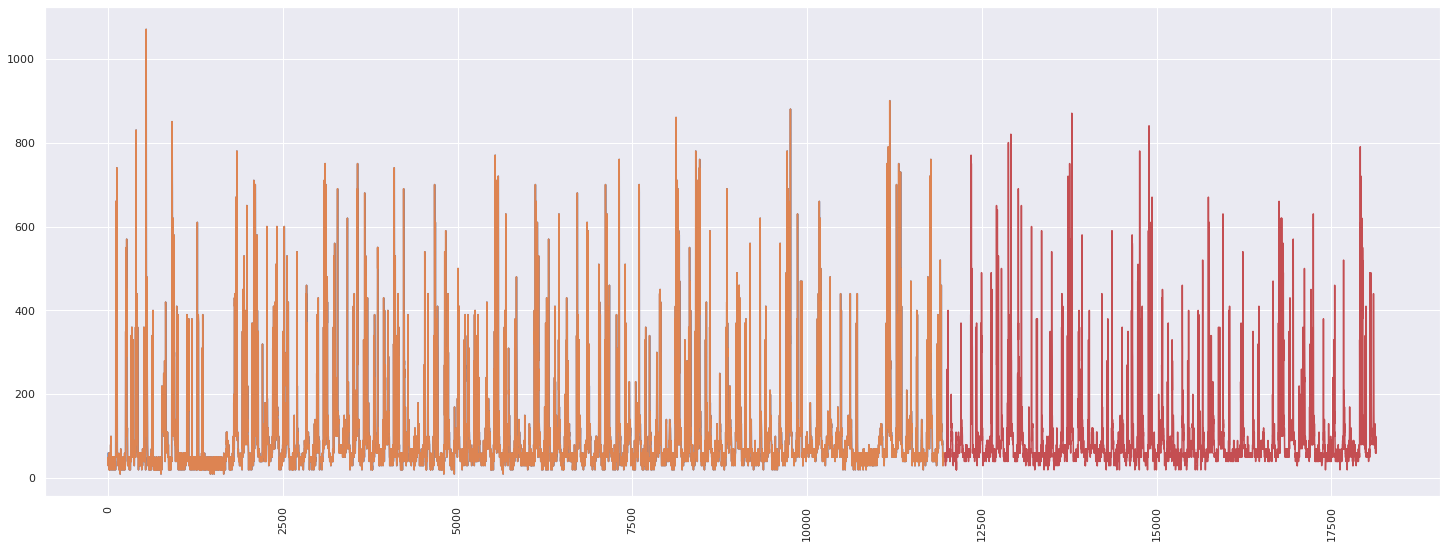

In [337]:
fig = plt.figure()
plt.xticks(rotation=90)
plt.plot(train_a)
plt.plot([None for i in train_a[:,1]] + [x for x in test_a[:,1]], color='r');
plt.show()

In [389]:
def model_persistence(x):
    return x

Luego de crear la funcion del modelo, se realiza una validación *walk-forward*.

In [390]:
# walk-forward validation
mp_predictions = [] # predicciones modelo persistencia
for x in test_ax:
    yhat = model_persistence(x)
    mp_predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_ay, mp_predictions))

In [340]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 66.583


El RMSE resultante fue de 66.5% el cual es un error muy alto, sin embargo, esperado dado la complejidad del modelo. Ahora veamos la comparación entre la predicción y los valores esperados.

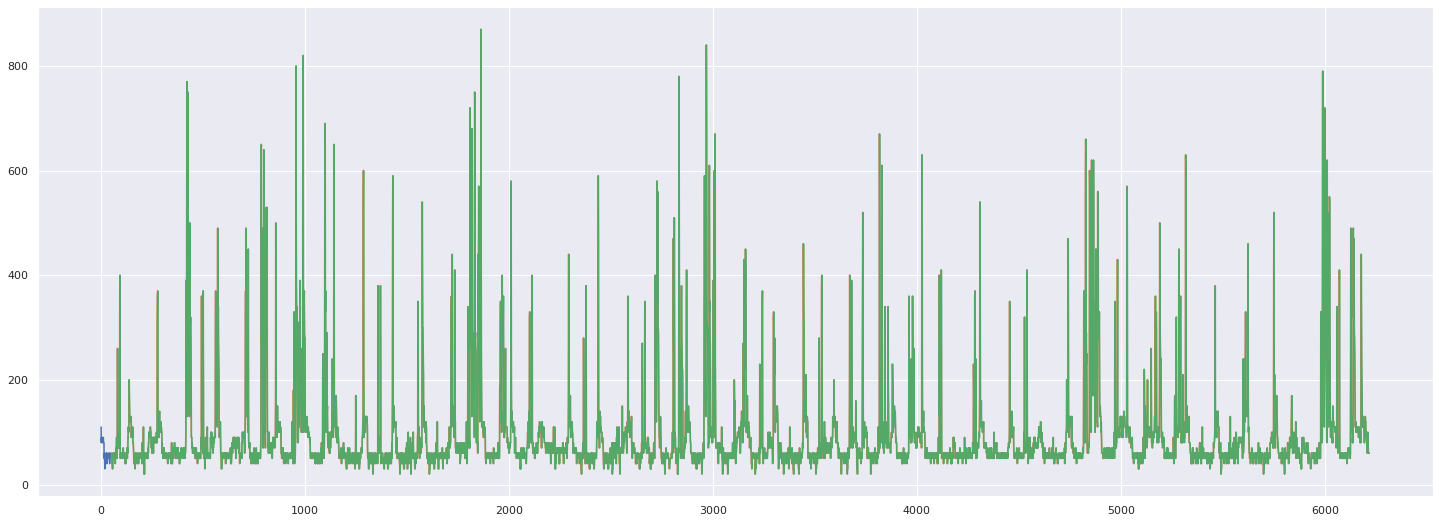

In [341]:
# plot predictions and expected results on the test data
plt.plot(train_ay[-50:])
plt.plot([None for i in train_ay[-50:]] + [x for x in test_ay])
plt.plot([None for i in train_ay[-50:]] + [x for x in mp_predictions]);

Veamos la gráfica anterior más de cerca.

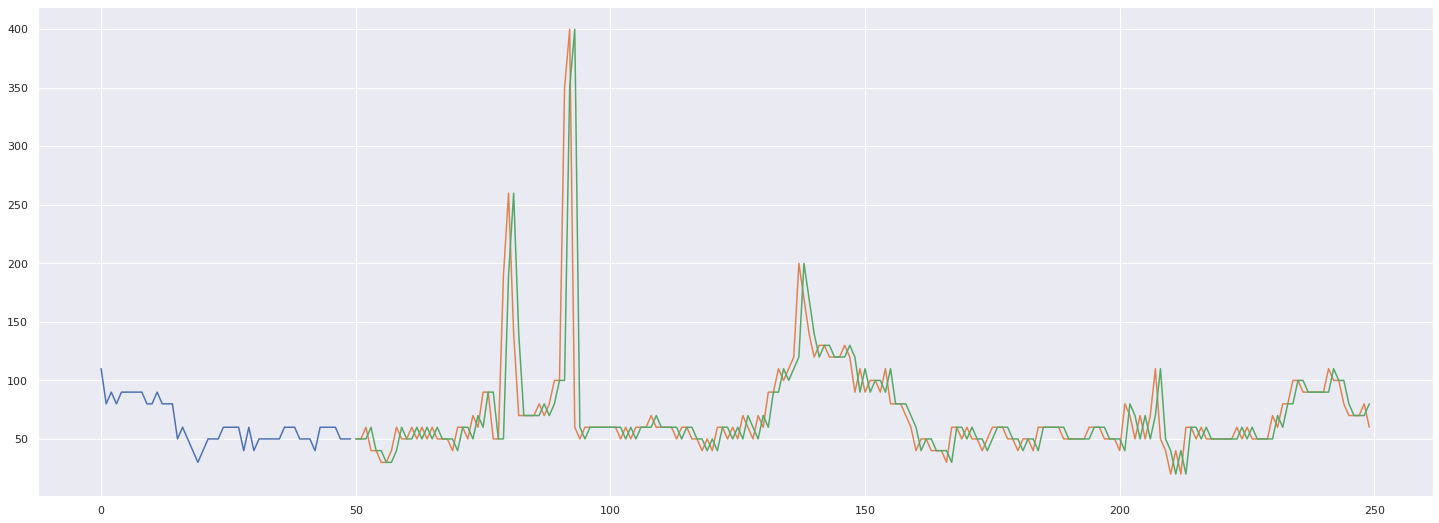

In [342]:
plt.plot(train_ay[-50:])
plt.plot([None for i in train_ay[-50:]] + [x for x in test_ay[:200]])
plt.plot([None for i in train_ay[-50:]] + [x for x in mp_predictions[:200]]);

También analizamos el comportamiento de los residuos del modelo. Esto es la diferencia entre valor real del conjunto de prueba y el valor predicho por el modelo.

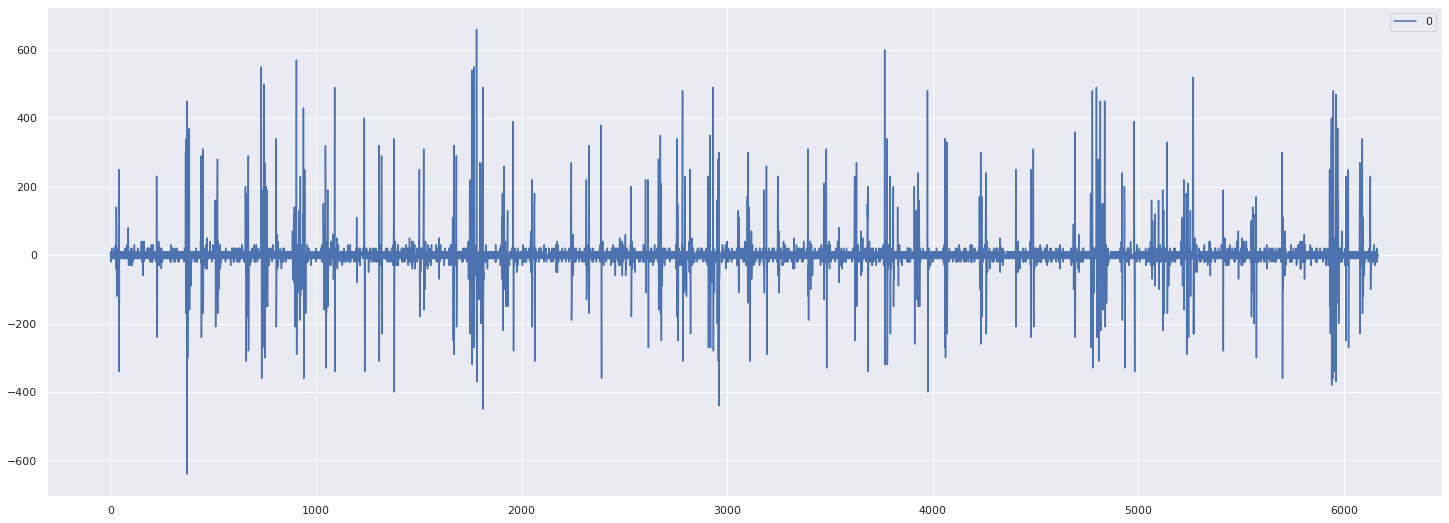

In [343]:
mp_residuals = [test_ay[i]-mp_predictions[i] for i in range(len(mp_predictions))]
mp_residuals = pd.DataFrame(mp_residuals)
mp_residuals.plot()

In [344]:
mp_residuals.describe()

,0
count,6169.000000
mean,0.001621
std,66.588760
min,-640.000000
25%,-10.000000
50%,0.000000
75%,10.000000
max,660.000000


La media de los residuos del modelo de persistencia es de $0.001$. Este resultado, acompañado de la gráfica muestra que el modelo tuvo una predicción muy cercana.

---

## Modelo AR

Como segundo modelo se realizará un modelo de *Auto Regresión* el cual brinda la librería *Statsmodels*. 

In [412]:
Xa = s_appli.values
train_size = int(len(Xa) * 0.66)
train_a, test_a = Xa[1:train_size], Xa[train_size:]

In [413]:
ar_mod = AR(train_a, lags = 13)
res = ar_mod.fit()
print('Lag: %s' % res.ar_lags)
print('Coefficients: %s' % res.params)

Lag: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Coefficients: [12.81023127  0.77606563 -0.14876545  0.05556085  0.02754344  0.01654059
  0.03335376 -0.06014834  0.03131511  0.06394157  0.05779593 -0.03318152
  0.03147519  0.01649778]


In [414]:
# make predictions
res = ar_mod.fit()
ar_predictions = res.predict(start=len(train_a), end=len(train_a)+len(test_a)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test_a[:test_period], ar_predictions[:test_period]))

In [415]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.785


El RMSE encontrado muestra que el modelo de AR tiene mejor desempeño en comparación con el modelo de persistencia. Ahora veamos el comportamiento de las predicciones.

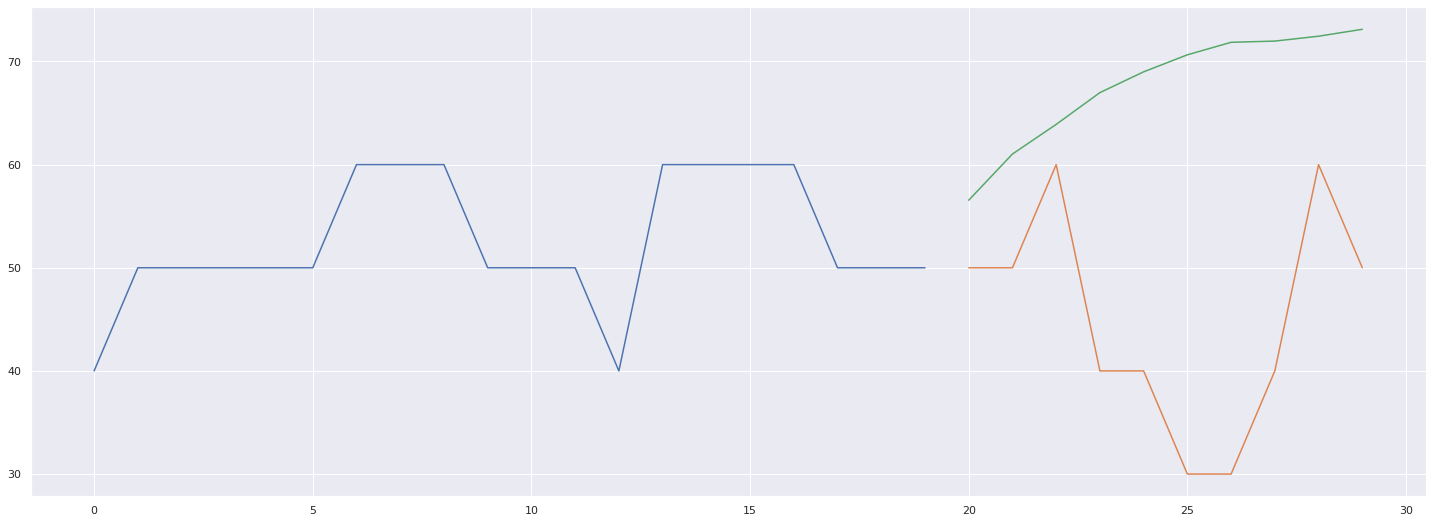

In [419]:
# plot predictions and expected results on the test data
test_period = 10
plt.plot(train_ay[-20:])
plt.plot([None for i in train_ay[-20:]] + [x for x in test_ay[:test_period]])
plt.plot([None for i in train_ay[-20:]] + [x for x in ar_predictions[:test_period]]);

Los residuos del modelo se ven a continuación.

<AxesSubplot:>

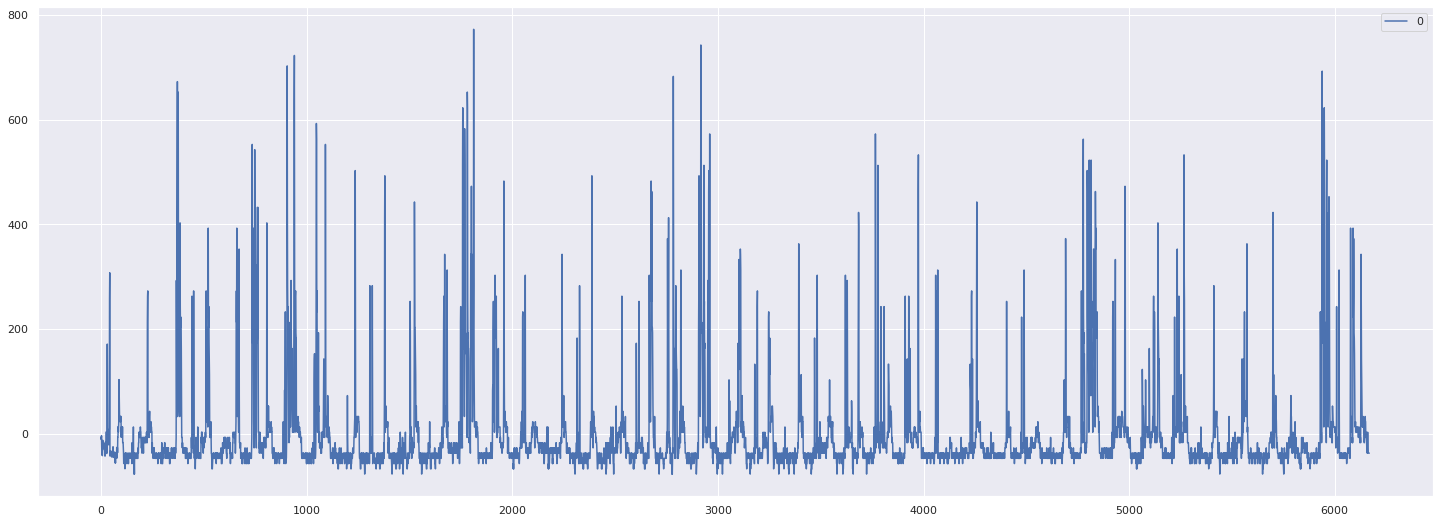

In [421]:
ar_residuals = [test_ay[i]-ar_predictions[i] for i in range(len(ar_predictions))]
ar_residuals = pd.DataFrame(ar_residuals)
ar_residuals.plot()

In [422]:
ar_residuals.describe()

,0
count,6169.000000
mean,-2.524761
std,90.893624
min,-77.043202
25%,-47.043202
50%,-37.043201
75%,2.956798
max,772.956798


Encontramos que la media de los residuios del modelo es de $-2.52$ lo cual está alejado de cero y muestra baja presición en la predicción.

---

## Modelo ARIMA

Como tercer modelo se implementó el modelo *ARIMA* con la técnica de walk-forward validation.

In [428]:
X = s_appli.values
history = [x for x in train_a]
arima_predictions = []
import time

In [429]:
%%time
from ipywidgets import IntProgress
from IPython.display import display

print('Barra de progreso:')

f = IntProgress(min=0, max=len(test_a)) # Barra de progreso
display(f)

for t in range(len(test_a)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_a[t]
    history.append(obs)
    f.value += 1 # aumento de la barra

Barra de progreso:


IntProgress(value=0, max=6169)

CPU times: user 1h 2min 52s, sys: 32min 2s, total: 1h 34min 54s
Wall time: 53min 53s


In [430]:
from copy import deepcopy
PREDICTIONS = deepcopy(arima_predictions)
HISTORY = deepcopy(history)
rmse = np.sqrt(mean_squared_error(test_a, PREDICTIONS))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 62.070


El modelo ARIMA tiene un error de $62.07$ el cual es peor comparado con los dos modelos vistos anteriormente. Así se ven los datos predichos vs los datos reales.

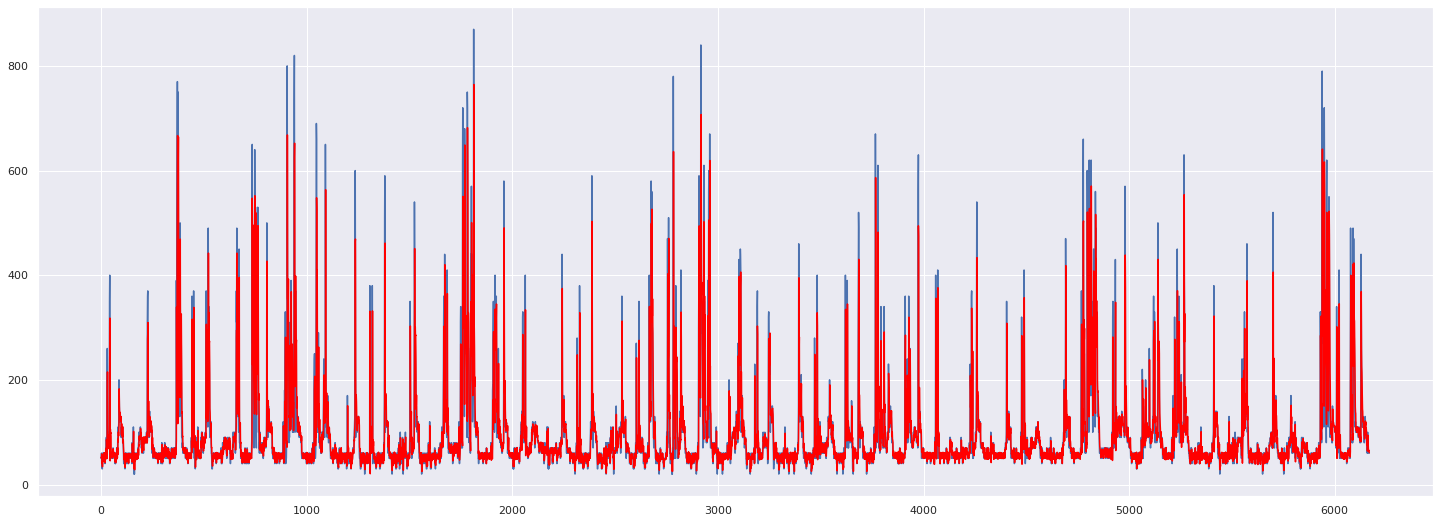

In [366]:
plt.plot(test_a)
plt.plot(arima_predictions, color='red');

Debido a que son muchos datos, se puede ver la gráfica anterior un poco más de cerca:

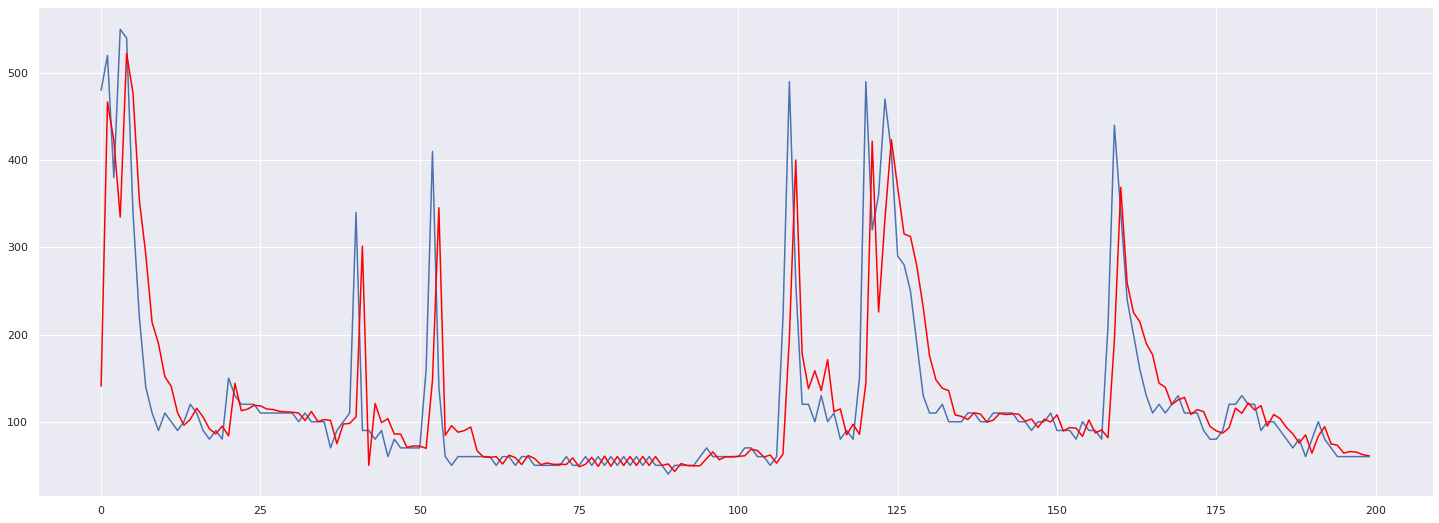

In [368]:
plt.plot(test_ay[-200:])
plt.plot(arima_predictions[-200:], color='red')
plt.show()

<AxesSubplot:>

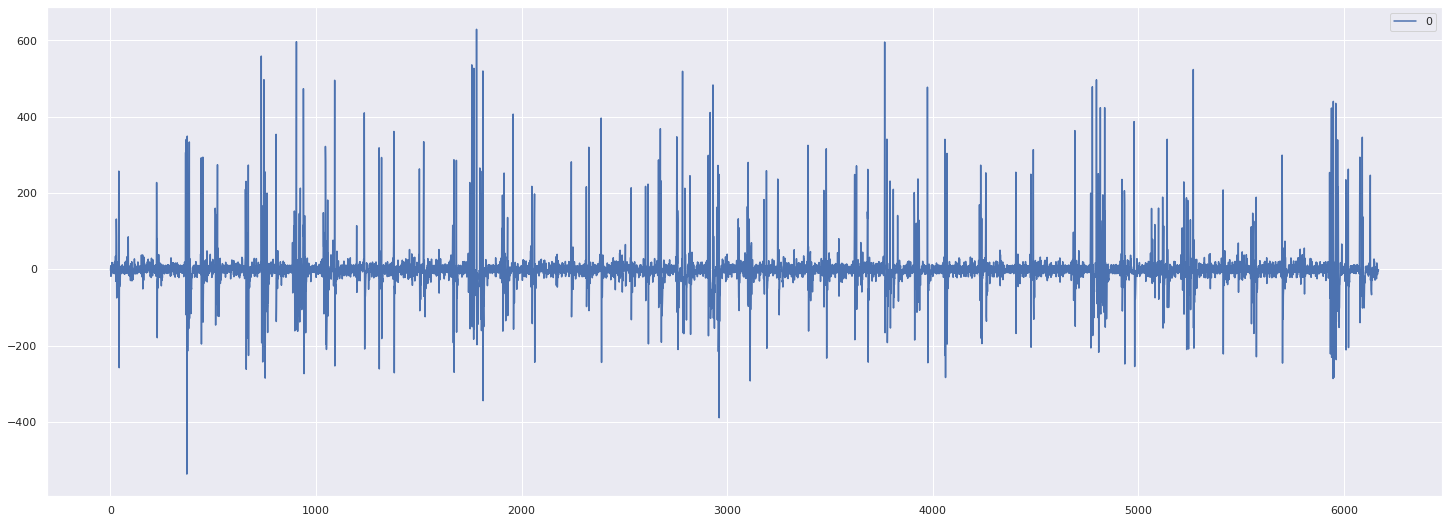

In [396]:
arima_residuals = [test_ay[i]-arima_predictions[i] for i in range(len(arima_predictions))]
arima_residuals = pd.DataFrame(arima_residuals)
arima_residuals.plot()

In [397]:
arima_residuals.describe()

,0
count,6169.000000
mean,-0.003484
std,62.074572
min,-536.932552
25%,-11.593207
50%,-1.349406
75%,8.921769
max,629.126689


En este caso, el modelo ARIMA, por medio de los residuos, muestra una grán presición de predicción.

---
## Random Forest

Ahora haremos la implementación de algunos modelos clásicos del aprendizaje automático como lo son el *Random Forest* y *Regresión Lineal*.

In [399]:
train_DateX, test_DateX = s_appli.index[:train_size], s_appli.index[train_size:]

In [400]:
# Separar horas y minutos de la fecha
df_train_hour = pd.DataFrame(train_DateX)
df_test_hour = pd.DataFrame(test_DateX)

dias_train = []
hour_train = []
hour_test  = []
dias_test  = []

for i in range(len(df_train_hour)):
    dias_train.append(df_train_hour["date"][i].split())

for i in range(len(df_test_hour)):
    dias_test.append(df_test_hour["date"][i].split())
    
    
for i in range(len(df_train_hour)):
    hour_train.append(dias_train[i][1].split(":")[0])
    
for i in range(len(df_test_hour)):
    hour_test.append(dias_test[i][1].split(":")[0])

In [401]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=500,random_state=100)

hour_train = np.array(hour_train[1:11975]).reshape(-1,1) 
hour_test = np.array(hour_test).reshape(-1,1) 

regressor.fit(hour_train, train_ay)


forest_predictions = regressor.predict(hour_test)

np.sqrt(mean_squared_error(test_ay ,forest_predictions))

86.46473614841132

<AxesSubplot:>

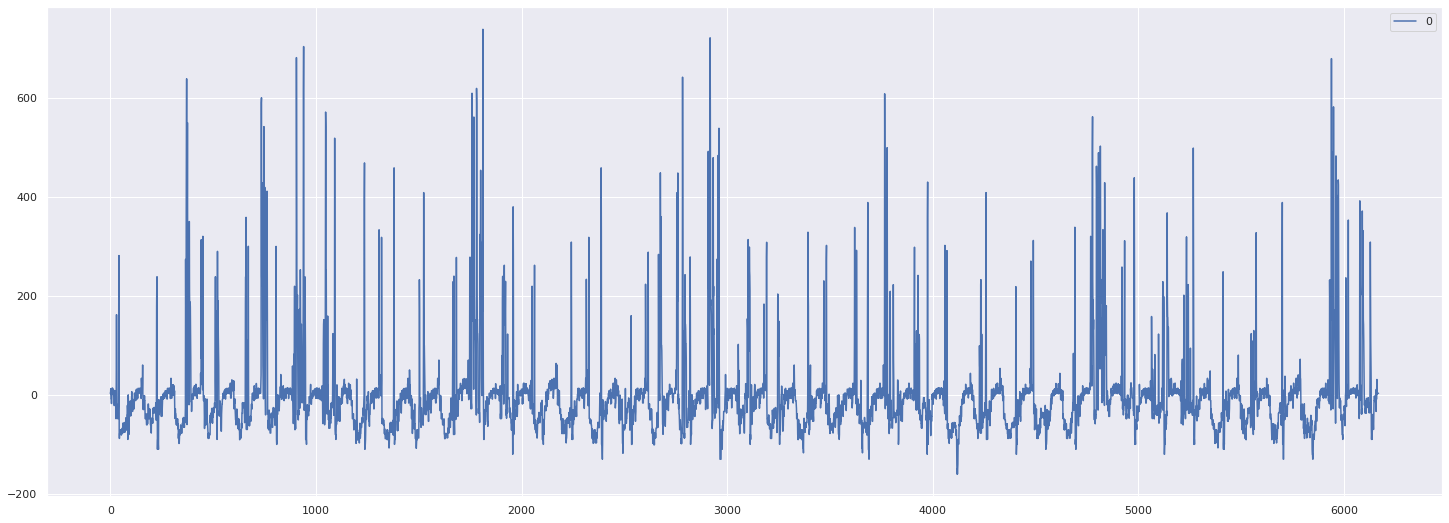

In [402]:
forest_residuals = [test_ay[i]-forest_predictions[i] for i in range(len(forest_predictions))]
forest_residuals = pd.DataFrame(forest_residuals)
forest_residuals.plot()

In [404]:
forest_residuals.describe()

,0
count,6169.000000
mean,-2.806161
std,86.426193
min,-160.249329
25%,-47.526395
50%,-11.882850
75%,8.109697
max,738.481832


Con un RMSE del $86.4$ y una media de los residuos de $-2.8$ encontramos que el modelo no es el más adecuado para realizar predicciones en este caso.

---
## Regresión lineal clásica

In [372]:
from sklearn import linear_model

X = df_complete.drop(columns = ['Appliances'])
X_train = X[:len(train_ay)]
X_test = X[len(train_ay)+1:]

lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, train_ay)

y_pred_test = lin_model.predict(X_test)

np.sqrt(mean_squared_error(test_ay ,y_pred_test))

85.9842577018141

In [373]:
lin_model.coef_

array([  2.07728356, -14.56541003,   7.19619493,  -4.95766518,
        -8.56214145,  30.89273158,  10.85137127,  -6.7430904 ,
        -3.29787283,  -2.99371237,   0.17255211,   1.75289442,
        -0.21265257,   3.08762086,  -1.45447592,  13.49994427,
        -3.74835106, -22.68393421,  -2.33838059, -15.19434865,
         0.13214689,  -2.109561  ,   0.53046397,   0.18733598,
        17.73792895,  42.79287274])

El RMSE arrojado por el modelo de Regresión Lineal clásico muestra un resultado muy similar al del modelo *Random Forest* en cuanto a la predicción. Por otro lado, se destaca el resultado de los coeficientes del modelo, pues el coeficiente relacionado con la variable *Day_state*, ingresada al inicio del notebook, tiene mucha influencia en la variable respuesta.

## Evaluación de los modelos propuestos

In [374]:
from sklearn.model_selection import TimeSeriesSplit
X = s_appli.values
splits = TimeSeriesSplit(n_splits=10)

errors_ar = []
errors_arima = []

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    #print(train)
    
    print('\nObservations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))
    
    print('='*10 + 'Modelo de AR' + '='*10)
    ar_mod = AR(train_a, lags = 13)
    res = ar_mod.fit()
    ar_predictions = res.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    ar_rmse = np.sqrt(mean_squared_error(test, ar_predictions))
    errors_ar.append(ar_rmse)
    print('Test RMSE: %.3f\n' % ar_rmse)
    
    print('='*10 + 'Modelo ARIMA' + '='*10)
    arima_mod = ARIMA(history, order=(5,1,0))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
    errors_arima.append(arima_rmse)
    print('Test RMSE: %.3f\n' % arima_rmse)


Observations: 3303
Training Observations: 1654
Testing Observations: 1649
-----
==========Modelo de AR==========
Test RMSE: 33.756

==========Modelo ARIMA==========
Test RMSE: 74.763


Observations: 4952
Training Observations: 3303
Testing Observations: 1649
-----
==========Modelo de AR==========
Test RMSE: 29.085

==========Modelo ARIMA==========
Test RMSE: 69.312


Observations: 6601
Training Observations: 4952
Testing Observations: 1649
-----
==========Modelo de AR==========
Test RMSE: 27.658

==========Modelo ARIMA==========
Test RMSE: 70.495


Observations: 8250
Training Observations: 6601
Testing Observations: 1649
-----
==========Modelo de AR==========
Test RMSE: 29.542

==========Modelo ARIMA==========
Test RMSE: 67.594


Observations: 9899
Training Observations: 8250
Testing Observations: 1649
-----
==========Modelo de AR==========
Test RMSE: 30.359

==========Modelo ARIMA==========
Test RMSE: 72.626


Observations: 11548
Training Observations: 9899
Testing Observations: 1649

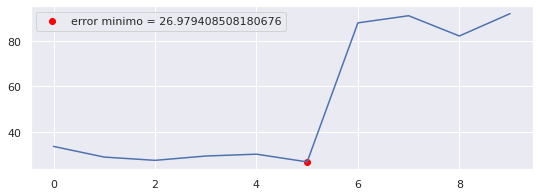

In [375]:
fig = plt.figure(figsize = (9,3))
plt.plot(errors_ar)
m = min(errors_ar)
idx = errors_ar.index(m)
plt.scatter(idx, m, color = 'red', label = f'error minimo = {m}')
plt.legend()
plt.show()

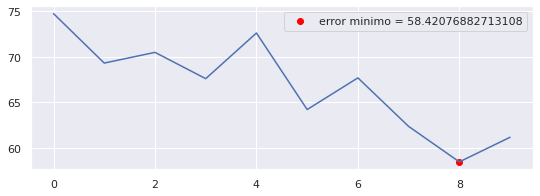

In [376]:
fig = plt.figure(figsize = (9,3))
plt.plot(errors_arima)
m = min(errors_arima)
idx = errors_arima.index(m)
plt.scatter(idx, m, color = 'red', label = f'error minimo = {m}')
plt.legend()
plt.show()

In [377]:
X = df_complete.drop(columns = 'Appliances')
y = df_complete['Appliances']
errors_rl = []
for q in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10)
    lin_model = linear_model.LinearRegression()
    lin_model.fit(X_train, y_train)

    y_pred_test = lin_model.predict(X_test)
    
    rl_rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))

    errors_rl.append(rl_rmse)   
    print('Test RMSE: %.3f\n' % rl_rmse)

Test RMSE: 92.724

Test RMSE: 89.047

Test RMSE: 90.236

Test RMSE: 88.254

Test RMSE: 96.431

Test RMSE: 88.670

Test RMSE: 94.027

Test RMSE: 85.921

Test RMSE: 83.401

Test RMSE: 85.337



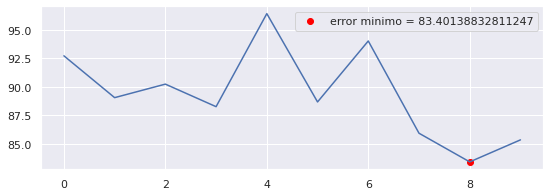

In [378]:
fig = plt.figure(figsize = (9,3))
plt.plot(errors_rl)
m = min(errors_rl)
idx = errors_rl.index(m)
plt.scatter(idx, m, color = 'red', label = f'error minimo = {m}')
plt.legend()
plt.show()

## Conclusiones

El exploracion de datos previo a el analisis de los mismos, resulta muy importante en el estudio de series temporales, para poder entender mejor el problema que se esta estudiando, y asi poder complementar los datos y hacer mas sencillo su análisis. Se ha notado la necesidad de hacer la prueba Dickey Fuller para lograr identificar la estacionalidad de los datos la cual es necesaria para lograr modelar y predecir los datos con cierta fidelidad, con modelos como ARIMA y AR los cuales se realizan sobre bases estacionarias.

Se vio reflejada la importancia del contexto de la base de datos, aporta una idea del porqué de los datos que vienen incluidos en la misma, a partir de esto se ve reflejado el desarrollo y entendimiento de la misma cuando se realiza la función que dicta el amanecer y anochecer de la zona horaria del origen de la base de datos la cual es Bélgica, lugar donde el amanecer y anochecer cambia con cada mes, esto es importante resaltarlo ya que es una variable exógena adicional para que los modelos usados en el proyecto se tornen mejores al momento de predecir los datos.

Dada la densidad de los datos y su dispersión, podemos ver afectaciones directas al RMSE por modelo el cual es mayor que lo normal que los mismos modelos en otras bases de datos, por lo mismo podemos notar los errores mayores que lo normal. El modelo de percepción parece ser muy acertado aunque no resulta eficiente para la predicción de conjuntos de datos más extensos. Esto es directamente por la defición de este modelo. Por otro lado, el modelo de AR muestra ser un mejor modelo con un RMSE menor que los demás modelos. Sin embargo, el ARIMA mostró un muy buen desempeño en la predicción con una media de residuos de $-0.003$. Además, el modelo de regresión lineal clásico mostró que el estado del día es MUY determinante para la variable respuesta. Esto es razonable, pues el consumo de energía de un hogar cambia dependiendo si está de día o de noche.